<h1>TASK 3. SAMPLING OF MULTIVARIATE RANDOM VARIABLES</h1>

<a name='000'></a>

<h2>Content</h2>

<ul>
    <ol type='1'>
    <li><a href='#001'>Substantiation of Chosen Sampling</a></li>
    <li><a href='#002'>Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods</a></li>
    <li><a href='#003'>Estimation of Relations Between Predictors and Chosen Target Variables</a></li>
    <li><a href='#004'>Bayesian Network</a></li>
    <li><a href='#005'>Quality Analysis</a></li>
    </ol>
</ul>

<h2>0. Environment Setup</h2>

<a href='#000'>Back</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

from pgmpy.estimators import HillClimbSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG

In [2]:
warnings.filterwarnings(action='ignore')

<a name='001'></a>

<h2>1. Substantiation of Chosen Sampling</h2>

<a href='#000'>Back</a>

Dataset name: Heart Disease Data Set

Dataset source: https://www.kaggle.com/ronitf/heart-disease-uci/version/1

Dataset content:
- age of patient
- sex of patient
- chest pain type
- resting blood pressure
- serum cholestoral
- fasting blood sugar
- resting electrocardiographic results
- maximum heart rate achieved
- exercise induced angina
- ST depression induced by exercise relative to rest
- slope of the peak exercise ST segment
- number of major vessels colored by flourosopy
- thal

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df = df[['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target', 'slope']]

q75, q25 = np.percentile(df['age'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['age'] < min_dist) | (df['age'] > max_dist), ('age')] = np.nan

q75, q25 = np.percentile(df['trestbps'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['trestbps'] < min_dist) | (df['trestbps'] > max_dist), ('trestbps')] = np.nan

q75, q25 = np.percentile(df['chol'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['chol'] < min_dist) | (df['chol'] > max_dist), ('chol')] = np.nan

q75, q25 = np.percentile(df['thalach'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['thalach'] < min_dist) | (df['thalach'] > max_dist), ('thalach')] = np.nan

q75, q25 = np.percentile(df['oldpeak'], [75, 25])
interval = q75 - q25
min_dist = q25 - (1.5 * interval)
max_dist = q75 + (1.5 * interval)
df.loc[(df['oldpeak'] < min_dist) | (df['oldpeak'] > max_dist), ('oldpeak')] = np.nan

df.dropna(inplace=True)

In [7]:
df.head(10)

,age,sex,cp,trestbps,chol,thalach,oldpeak,ca,target,slope
0,63.0,1,3,145.0,233.0,150.0,2.3,0,1,0
1,37.0,1,2,130.0,250.0,187.0,3.5,0,1,0
2,41.0,0,1,130.0,204.0,172.0,1.4,0,1,2
3,56.0,1,1,120.0,236.0,178.0,0.8,0,1,2
4,57.0,0,0,120.0,354.0,163.0,0.6,0,1,2
5,57.0,1,0,140.0,192.0,148.0,0.4,0,1,1
6,56.0,0,1,140.0,294.0,153.0,1.3,0,1,1
7,44.0,1,1,120.0,263.0,173.0,0.0,0,1,2
9,57.0,1,2,150.0,168.0,174.0,1.6,0,1,2
10,54.0,1,0,140.0,239.0,160.0,1.2,0,1,2


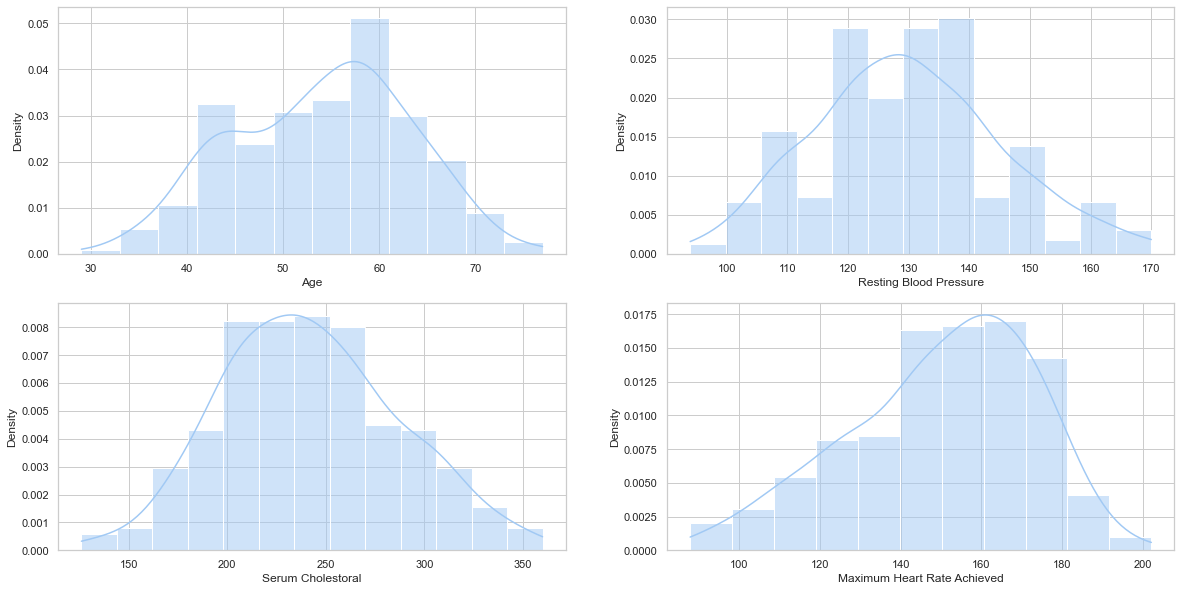

In [9]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

age = sns.histplot(df.age, ax=ax[0, 0], kde=True, stat='density')
age.set(xlabel='Age')

trestbps = sns.histplot(df.trestbps, ax=ax[0, 1], kde=True, stat='density')
trestbps.set(xlabel='Resting Blood Pressure')

chol = sns.histplot(df.chol, ax=ax[1, 0], kde=True, stat='density')
chol.set(xlabel='Serum Cholestoral')

thalach = sns.histplot(df.thalach, ax=ax[1, 1], kde=True, stat='density')
thalach.set(xlabel='Maximum Heart Rate Achieved')

plt.show()

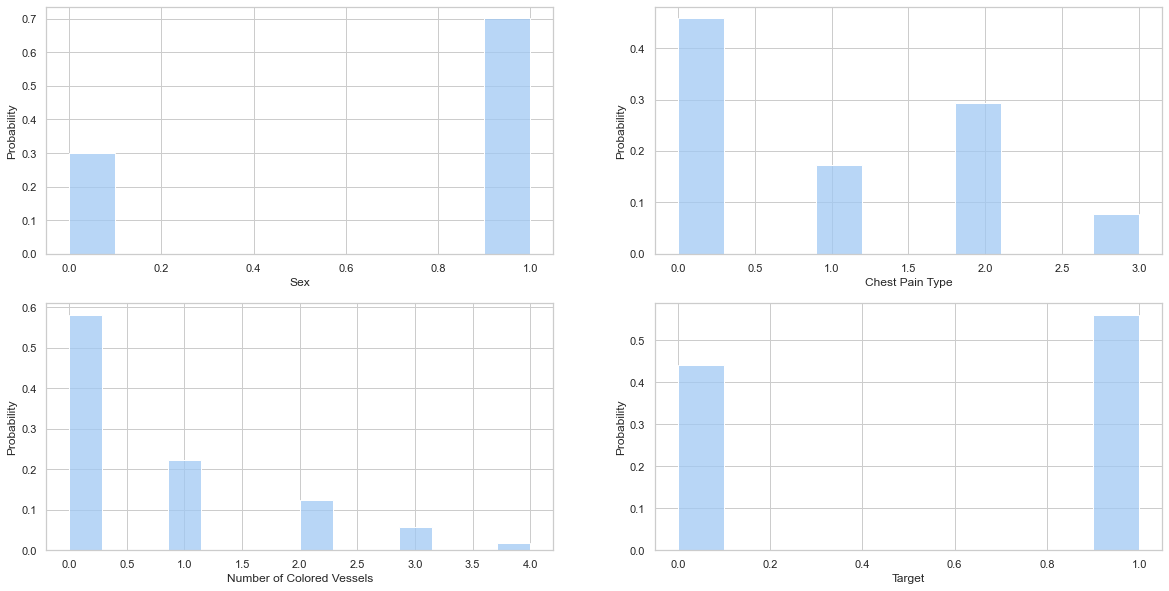

In [10]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sex = sns.histplot(df.sex, ax=ax[0, 0], kde=False, stat='probability')
sex.set(xlabel='Sex')

cp = sns.histplot(df.cp, ax=ax[0, 1], kde=False, stat='probability')
cp.set(xlabel='Chest Pain Type')

ca = sns.histplot(df.ca, ax=ax[1, 0], kde=False, stat='probability')
ca.set(xlabel='Number of Colored Vessels')

target = sns.histplot(df.target, ax=ax[1, 1], kde=False, stat='probability')
target.set(xlabel='Target')

plt.show()

<a name='002'></a>

<h2>2. Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods</h2>

<a href='#000'>Back</a>

In [11]:
df_sample = df.sample(frac=0.5)

In [12]:
df_split, _ = train_test_split(df, test_size=0.5)

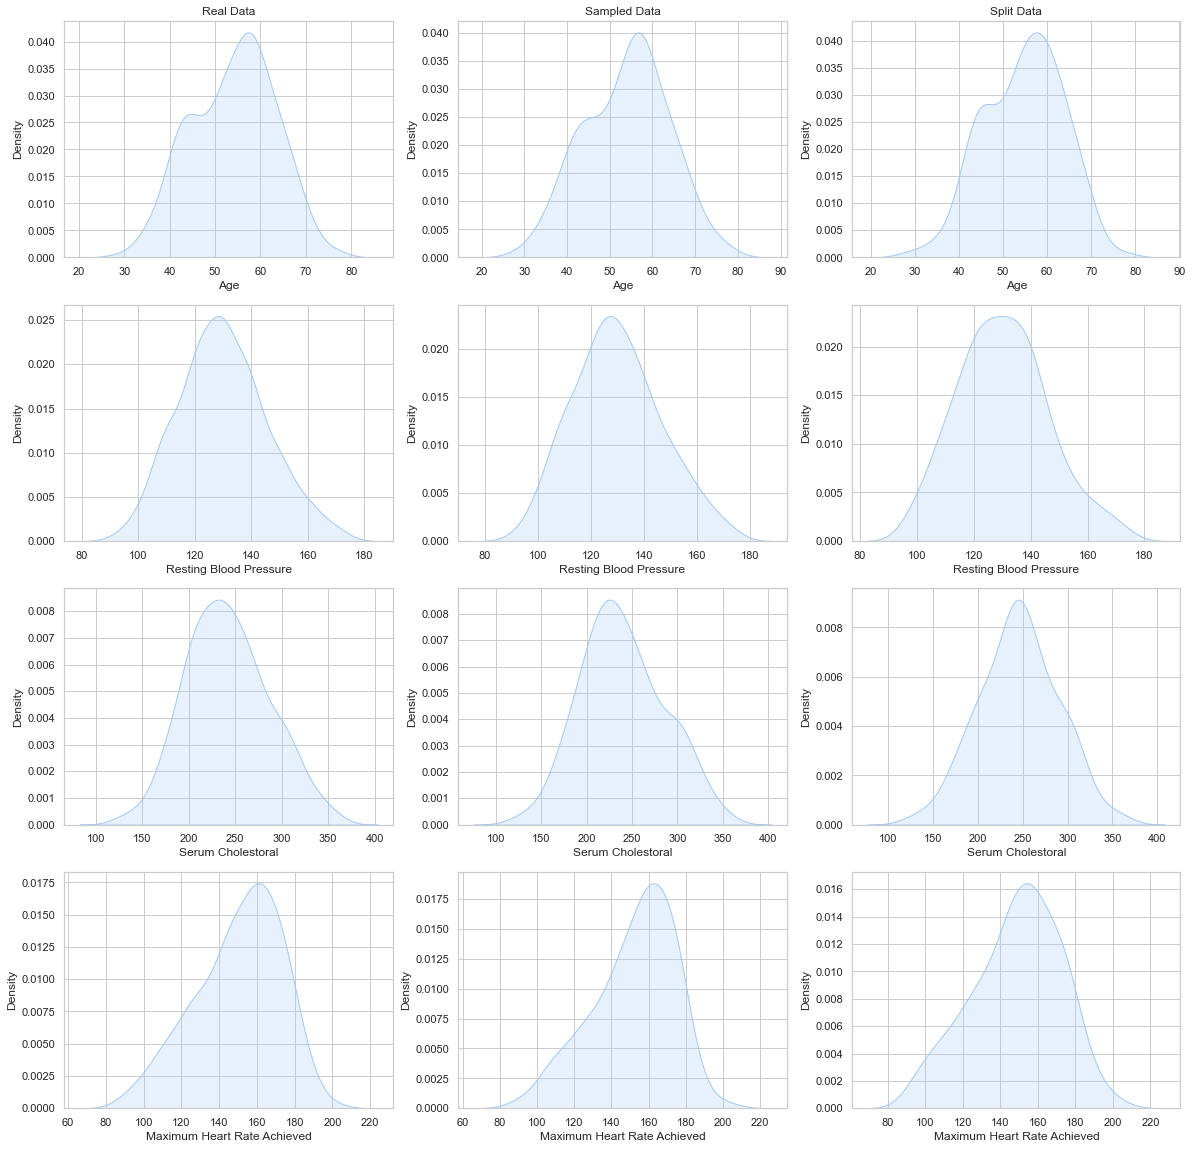

In [13]:
figure, ax = plt.subplots(4, 3, figsize=(20, 20))
sns.set_theme(style='whitegrid', palette='pastel')

sns.kdeplot(df.age, ax=ax[0, 0], shade=True)
sns.kdeplot(df_sample.age, ax=ax[0, 1], shade=True)
sns.kdeplot(df_split.age, ax=ax[0, 2], shade=True)

sns.kdeplot(df.trestbps, ax=ax[1, 0], shade=True)
sns.kdeplot(df_sample.trestbps, ax=ax[1, 1], shade=True)
sns.kdeplot(df_split.trestbps, ax=ax[1, 2], shade=True)

sns.kdeplot(df.chol, ax=ax[2, 0], shade=True)
sns.kdeplot(df_sample.chol, ax=ax[2, 1], shade=True)
sns.kdeplot(df_split.chol, ax=ax[2, 2], shade=True)

sns.kdeplot(df.thalach, ax=ax[3, 0], shade=True)
sns.kdeplot(df_sample.thalach, ax=ax[3, 1], shade=True)
sns.kdeplot(df_split.thalach, ax=ax[3, 2], shade=True)

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Sampled Data')
ax[0, 2].set_title('Split Data')

ax[0, 0].set(xlabel='Age')
ax[0, 1].set(xlabel='Age')
ax[0, 2].set(xlabel='Age')
ax[1, 0].set(xlabel='Resting Blood Pressure')
ax[1, 1].set(xlabel='Resting Blood Pressure')
ax[1, 2].set(xlabel='Resting Blood Pressure')
ax[2, 0].set(xlabel='Serum Cholestoral')
ax[2, 1].set(xlabel='Serum Cholestoral')
ax[2, 2].set(xlabel='Serum Cholestoral')
ax[3, 0].set(xlabel='Maximum Heart Rate Achieved')
ax[3, 1].set(xlabel='Maximum Heart Rate Achieved')
ax[3, 2].set(xlabel='Maximum Heart Rate Achieved')

plt.show()

Estimation of multivariate mathematical expectation and variance for sampled data.

In [14]:
df_sample[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean()

age          53.866197
trestbps    129.887324
chol        239.345070
thalach     151.894366
oldpeak       0.835915
dtype: float64

In [15]:
df_sample[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].var()

age           96.201828
trestbps     269.703526
chol        2076.014834
thalach      476.151883
oldpeak        0.953240
dtype: float64

Estimation of multivariate mathematical expectation and variance for split data.

In [16]:
df_split[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean()

age          54.605634
trestbps    130.190141
chol        245.535211
thalach     148.415493
oldpeak       1.004930
dtype: float64

In [17]:
df_split[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].var()

age           78.793727
trestbps     245.346569
chol        1961.059035
thalach      548.003446
oldpeak        0.986997
dtype: float64

<a name='003'></a>

<h2>3. Estimation of Relations Between Predictors and Chosen Target Variables</h2>

<a href='#000'>Back</a>

In [18]:
predictors = df[['cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']]
targets = df[['age', 'oldpeak', 'target']]

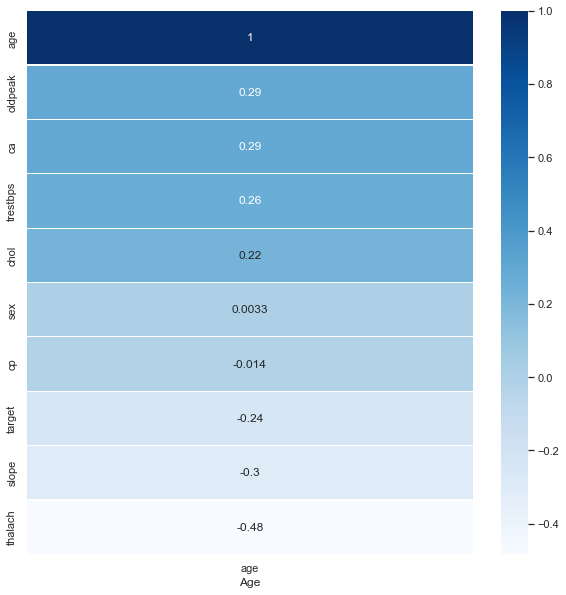

In [19]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df_sample.corr()[['age']].sort_values(by='age', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='Age')
plt.show()

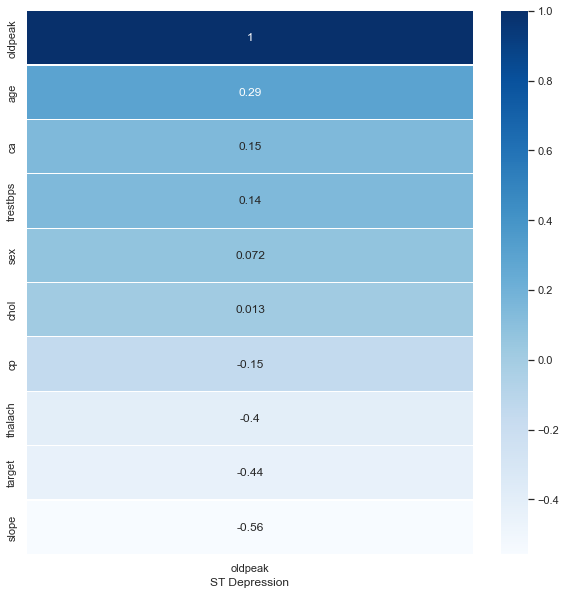

In [20]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df_sample.corr()[['oldpeak']].sort_values(by='oldpeak', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='ST Depression')
plt.show()

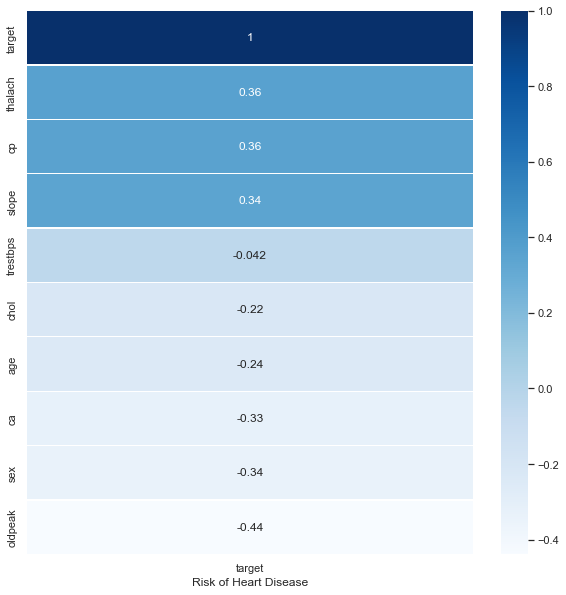

In [21]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(
    df_sample.corr()[['target']].sort_values(by='target', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25
)

ax.set(xlabel='Risk of Heart Disease')
plt.show()

<a name='004'></a>

<h2>4. Bayesian Network</h2>

<a href='#000'>Back</a>

In [22]:
df_transformed = df_sample.copy()
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df_sample.values[:, [0, 3, 4, 5, 6]])
df_transformed[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = df_discretized

In [23]:
hc_search = HillClimbSearch(data=df_transformed)
model_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))

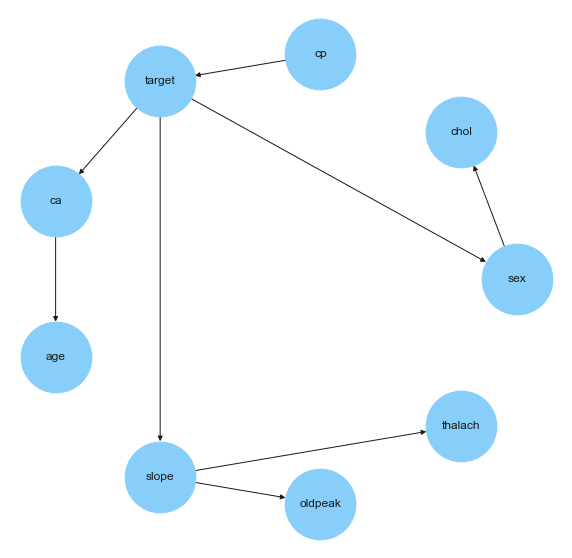

In [24]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_k2.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [25]:
black_list = [(x, y) for x in df_transformed.columns.to_list() for y in ['age'] if x != y]
black_list

[('sex', 'age'),
 ('cp', 'age'),
 ('trestbps', 'age'),
 ('chol', 'age'),
 ('thalach', 'age'),
 ('oldpeak', 'age'),
 ('ca', 'age'),
 ('target', 'age'),
 ('slope', 'age')]

In [26]:
model_bl = hc_search.estimate(black_list=black_list)

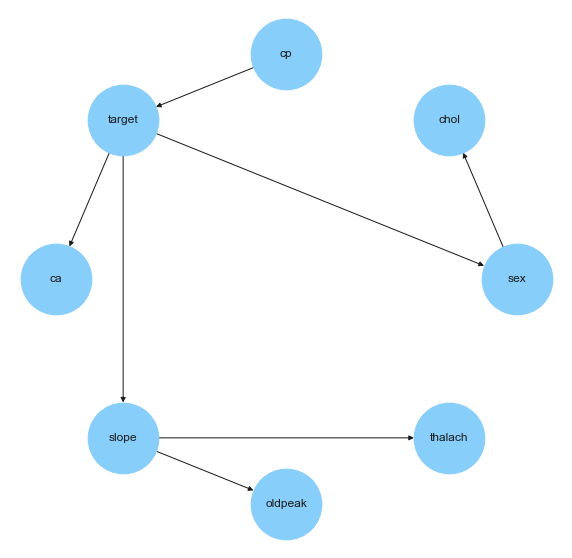

In [27]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_bl.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [28]:
hc_search = HillClimbSearch(data=df_transformed)
model_bic = hc_search.estimate(scoring_method=BicScore(df_transformed), black_list=black_list)

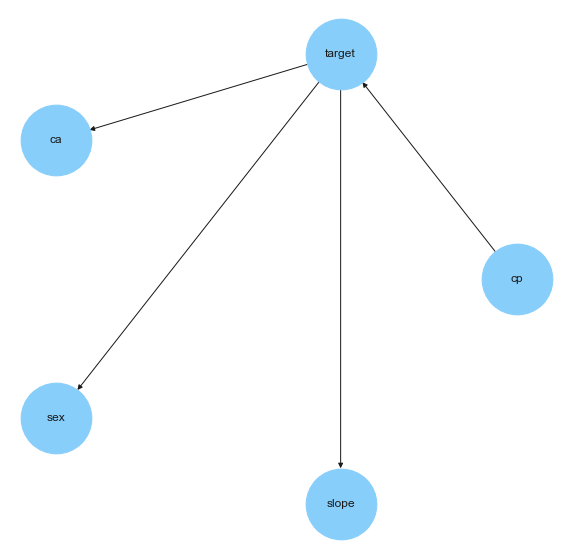

In [29]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(model_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

<a name='005'></a>

<h2>5. Quality Analysis</h2>

<a href='#000'>Back</a>

In [30]:
def return_sample(model, data, size):
    model_s = BayesianModel(model.edges())
    model_s.fit(data)
    
    sampling = BayesianModelSampling(model_s)
    sample = sampling.forward_sample(size=size)
    return sample

In [31]:
def return_histplot(target, data, sample_1, sample_2, sample_3):
    df_1 = pd.DataFrame()
    df_1[target] = data[target]
    df_1['Data'] = 'Original Data'
    df_1['Probability'] = df_1[target].apply(lambda x: (df_1.groupby(target)[target].count()[x])/data.shape[0])
    
    df_2 = pd.DataFrame()
    df_2[target] = sample_1[target]
    df_2['Data'] = 'K2Score'
    df_2['Probability'] = df_2[target].apply(lambda x: (df_2.groupby(target)[target].count()[x])/sample_1.shape[0])
    
    df_3 = pd.DataFrame()
    df_3[target] = sample_2[target]
    df_3['Data'] = 'BicScore'
    df_3['Probability'] = df_3[target].apply(lambda x: (df_3.groupby(target)[target].count()[x])/sample_2.shape[0])
    
    df_4 = pd.DataFrame()
    df_4[target] = sample_3[target]
    df_4['Data'] = 'Our Structure'
    df_4['Probability'] = df_4[target].apply(lambda x: (df_4.groupby(target)[target].count()[x])/sample_3.shape[0])
    
    df = pd.DataFrame()
    df = pd.concat([df_1, df_2, df_3, df_4])
    
    figure, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    
    sns.barplot(x=target, y='Probability', hue='Data', data=df, palette='Blues')
    
    plt.legend()
    plt.show()

Quality analysis for slope of the peak exercise ST segment.

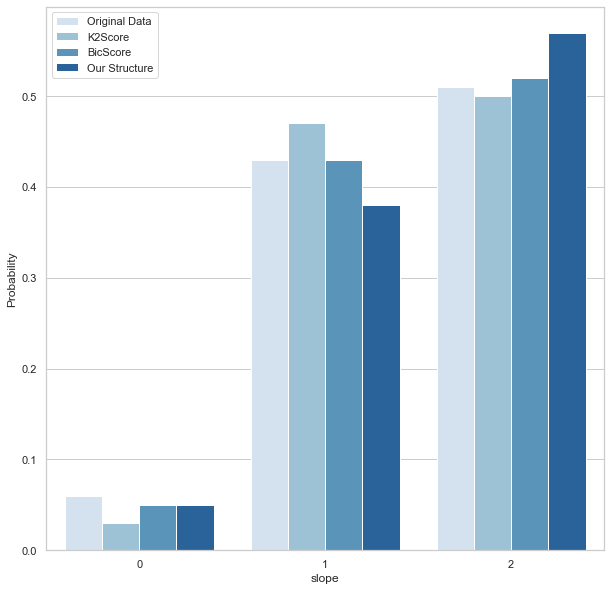

In [32]:
return_histplot(
    'slope',
    df_transformed[:100],
    return_sample(model_k2, df_transformed, 100)[:100],
    return_sample(model_bic, df_transformed, 100)[:100],
    return_sample(model_bl, df_transformed, 100)[:100]
)

Quality analysis for risk of heart disease.

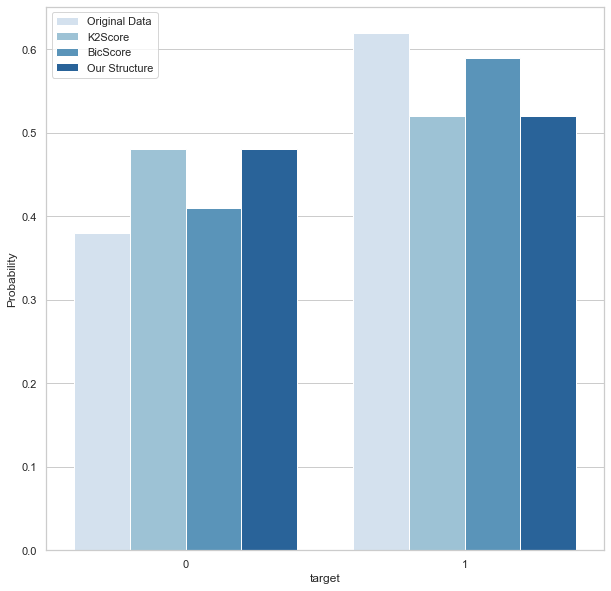

In [33]:
return_histplot(
    'target',
    df_transformed[:100],
    return_sample(model_k2, df_transformed, 100)[:100],
    return_sample(model_bic, df_transformed, 100)[:100],
    return_sample(model_bl, df_transformed, 100)[:100]
)

Quality analysis for chest pain type.

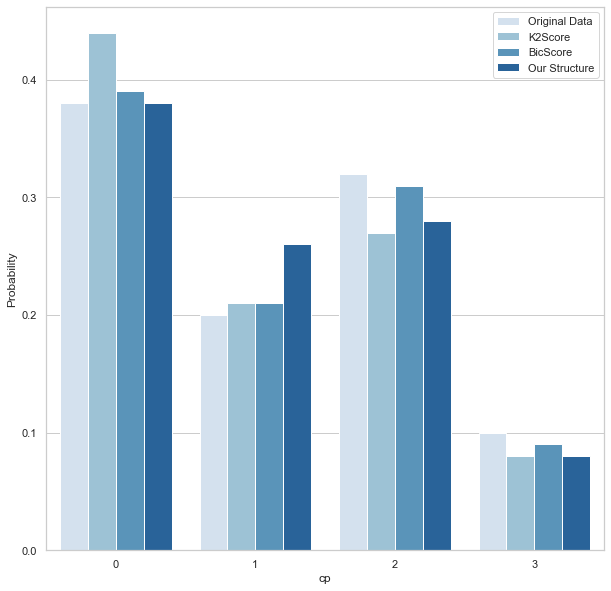

In [34]:
return_histplot(
    'cp',
    df_transformed[:100],
    return_sample(model_k2, df_transformed, 100)[:100],
    return_sample(model_bic, df_transformed, 100)[:100],
    return_sample(model_bl, df_transformed, 100)[:100]
)

Quality analysis for sex of patient.

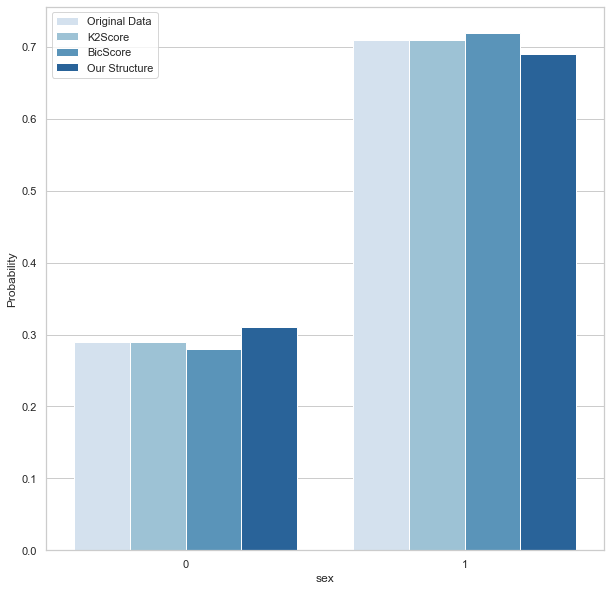

In [35]:
return_histplot(
    'sex',
    df_transformed[:100],
    return_sample(model_k2, df_transformed, 100)[:100],
    return_sample(model_bic, df_transformed, 100)[:100],
    return_sample(model_bl, df_transformed, 100)[:100]
)